# Cats v/s Dogs : Feature extraction from Pre-trained model 

Here we use a pretrained model named ImageNet, a VGG16 variant, and implement feature extraction


## STEP 1: Import the model

VGG16 model (imagenet) is imported, and Dense top layer is removed.

The solution can be attained in 2 ways:
1. **Separate blocks**: Process CNN block with input data and feed into a numpy array, then later feed numpy array into separate dense layer block (*adv: time, disadv: data augmentation*)
2. **Same blocks**: Attach CNN base to dense block, and feed data on the whole system, with data augmentation applied (*adv: data augmentation, disadv: time*)

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(150, 150, 3))
conv_base.summary()

## STEP 2a: Create datagen for CNN base and feed into Dense model

For method 1, we prepare numpy array input by processing the datagen into CNN base. Later, we feed the numpy flattened o/p into a dense model.

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


base_dir = 'D:\\Office Desk\\DL using python\\cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) #4x4 image window, 512 node outputs
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    
    #this block prepares a numpy o/p for each image
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


print('done')

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

done
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
from keras import models
from keras import layers
from keras import optimizers

train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))



model.save('cats_vs_dogs3a.h5')
print('training finished!!')

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 7s 3ms/step - loss: 0.6056 - acc: 0.6715 - val_loss: 0.4362 - val_acc: 0.8270
Epoch 2/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.4236 - acc: 0.8065 - val_loss: 0.3635 - val_acc: 0.8680
Epoch 3/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.3471 - acc: 0.8510 - val_loss: 0.3157 - val_acc: 0.8820
Epoch 4/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.3110 - acc: 0.8715 - val_loss: 0.2942 - val_acc: 0.8900
Epoch 5/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2782 - acc: 0.8880 - val_loss: 0.2794 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2625 - acc: 0.8925 - val_loss: 0.2680 - val_acc: 0.8970
Epoch 7/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2447 - acc: 0.9010 - val_loss: 0.2677 - val_acc: 0.8940
Epoch 8/30
200

### Plot result

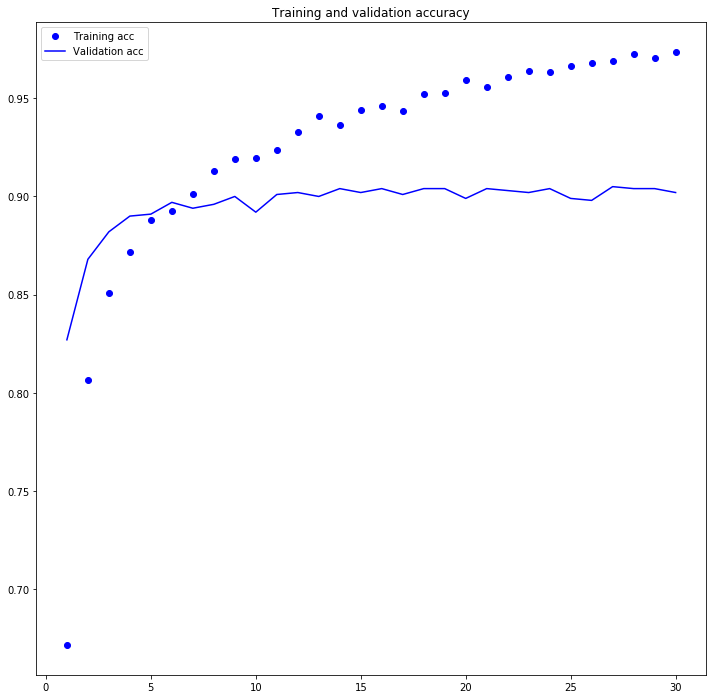

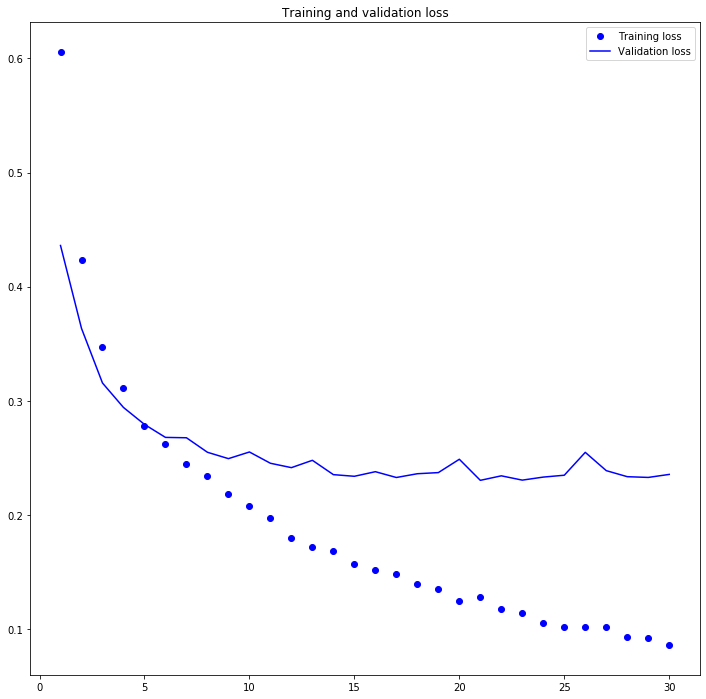

In [7]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.savefig("D:\\plot2a.jpg")

plt.figure(figsize=(12,12))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("D:\\plot2b.jpg")
plt.show()

## STEP 2b: Create a complete CNN base ->> Dense block integrated model

For method 2, an integrated system is created and data augmentation is successfully applied upon the whole model

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
train_dir,
target_size=(150,150),
batch_size=20,
class_mode='binary')

validation_generator=test_datagen.flow_from_directory(
validation_dir,
target_size=(150,150),
batch_size=20,
class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])


history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=30,validation_data=validation_generator,validation_steps=50)
model.save('cats_vs_dogs_v3b.h5')

Epoch 1/30
100/100 [==============================] - 9290s 93s/step - loss: 0.4925 - acc: 0.7480 - val_loss: 0.1182 - val_acc: 0.9320
Epoch 2/30
100/100 [==============================] - 1413s 14s/step - loss: 0.2758 - acc: 0.8860 - val_loss: 0.0262 - val_acc: 0.9440
Epoch 3/30
100/100 [==============================] - 1410s 14s/step - loss: 0.2340 - acc: 0.9070 - val_loss: 0.4829 - val_acc: 0.9060
Epoch 4/30
100/100 [==============================] - 1413s 14s/step - loss: 0.1816 - acc: 0.9260 - val_loss: 0.0062 - val_acc: 0.9640
Epoch 5/30
100/100 [==============================] - 1405s 14s/step - loss: 0.1668 - acc: 0.9430 - val_loss: 0.0443 - val_acc: 0.9490
Epoch 6/30
100/100 [==============================] - 1410s 14s/step - loss: 0.1300 - acc: 0.9430 - val_loss: 0.0680 - val_acc: 0.9650
Epoch 7/30
100/100 [==============================] - 1404s 14s/step - loss: 0.1143 - acc: 0.9540 - val_loss: 0.0017 - val_acc: 0.9650
Epoch 8/30
100/100 [==============================] - 1

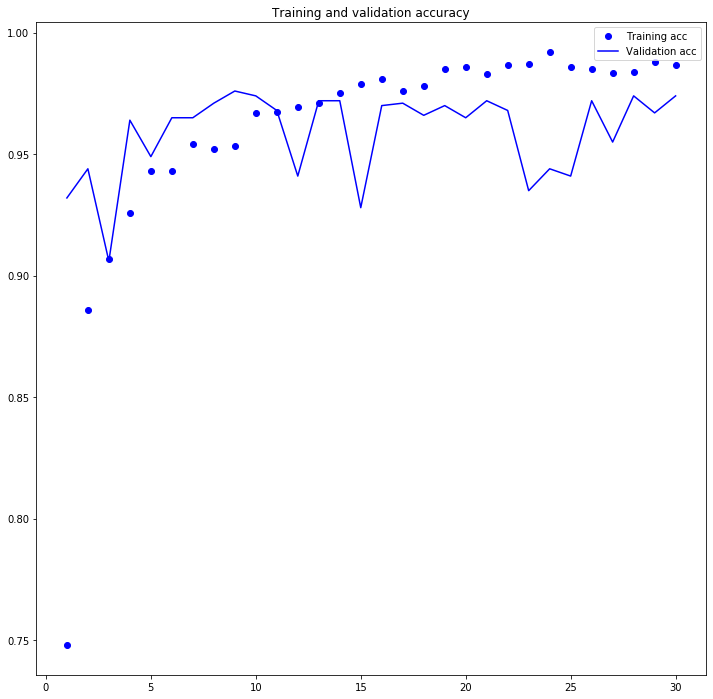

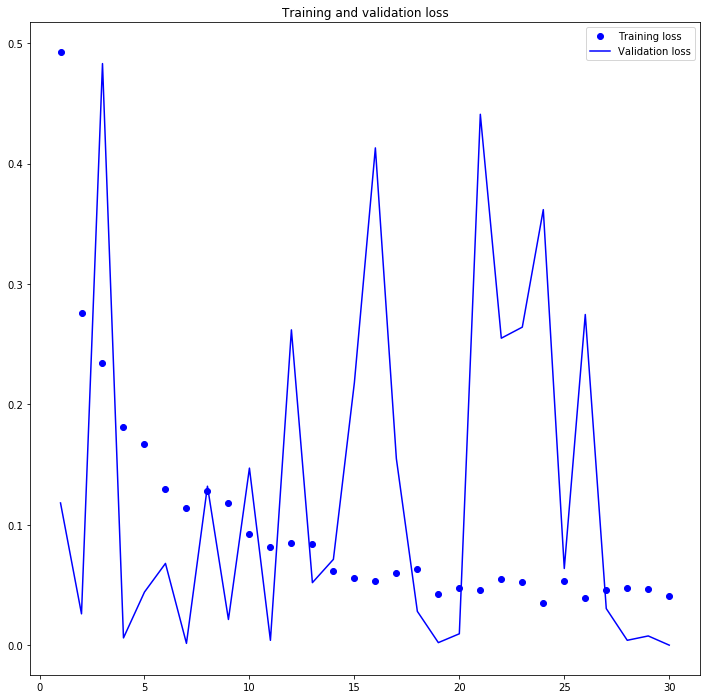

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.savefig("D:\\plot2A.jpg")

plt.figure(figsize=(12,12))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("D:\\plot2B.jpg")
plt.show()